#### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
#!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"
!cd gdrive/MyDrive/paris-saclay-ai-competition
!kaggle competitions download -c centralesupelec-summer-school-on-ai-2022
!unzip centralesupelec-summer-school-on-ai-2022.zip
!ls

Mounted at /content/gdrive
centralesupelec-summer-school-on-ai-2022.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  centralesupelec-summer-school-on-ai-2022.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: centralesupelec-summer-school-on-ai-2022.zip  sample_data	     test.csv
drive					      sample_submission.csv  train.csv
gdrive					      skeleton_code.py


In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('./train.csv/train.csv', index_col=0)
final_test_df = pd.read_csv('./test.csv/test.csv', index_col=0)
raw_df.head()


,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1


In [ ]:
raw_df[['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls', 'salutations', 'designation', 'chars_in_subject', 'chars_in_body']].describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body
count,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80160.000000,8.017600e+04
mean,0.473259,0.002869,7.875998,34.433172,0.406381,0.104246,51.535254,1.971784e+05
std,3.178805,0.053484,305.444093,97.904682,0.491160,0.305581,33.718283,1.890130e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00
25%,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,32.000000,4.651000e+03
50%,0.000000,0.000000,2.000000,17.000000,0.000000,0.000000,42.000000,1.999950e+04
75%,0.000000,0.000000,8.000000,44.000000,1.000000,0.000000,62.000000,4.519300e+04
max,179.000000,1.000000,83481.000000,21540.000000,1.000000,1.000000,606.000000,7.438108e+07


### Examine the class label imbalance

Let's look at the dataset imbalance:

This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [4]:
cleaned_df = raw_df.copy()

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['log_images'] = np.log(cleaned_df.pop('images')+eps)
cleaned_df['log_urls'] = np.log(cleaned_df.pop('urls')+eps)
cleaned_df['log_chars_in_body'] = np.log(cleaned_df.pop('chars_in_body')+eps)

# Parse dates and put in unix format

from dateutil import parser
from datetime import datetime
import time

def to_unix(date):
  return int(time.mktime(date.timetuple()))

def strip_formatting(date_string):
  first_paren = date_string.find(" (")
  if first_paren != -1:
    return date_string[:first_paren]
  return date_string

def string_to_unix(date_string):
  date_time = parser.parse(strip_formatting(date_string))
  return to_unix(date_time)

def datetime_obj(date_string):
  unix_time = string_to_unix(date_string)
  return datetime.fromtimestamp(unix_time)

def has_weekday(date_string):
  return date_string[0].isalpha()

def has_parentheses(date_string):
  return date_string.find("(") != -1

# train_df['date'][382] has parentheses
# train_df['date][924] has no weekday

# add new columns to data
cleaned_df['date_has_weekday'] = cleaned_df.apply(lambda row: has_weekday(row['date']), axis=1)
cleaned_df['date_has_parentheses'] = cleaned_df.apply(lambda row: has_parentheses(row['date']), axis=1)
final_test_df['date_has_weekday'] = final_test_df.apply(lambda row: has_weekday(row['date']), axis=1)
final_test_df['date_has_parentheses'] = final_test_df.apply(lambda row: has_parentheses(row['date']), axis=1)
# make date unix style
cleaned_df['date'] = cleaned_df.apply(lambda row: pd.Period(datetime_obj(row['date']), freq='H').day_of_year, axis=1)
final_test_df['date'] = final_test_df.apply(lambda row: pd.Period(datetime_obj(row['date']), freq='H').day_of_year, axis=1)


In [5]:
#print(train_df['tld'].value_counts().to_string())
tlds = pd.read_csv("https://gist.githubusercontent.com/derlin/421d2bb55018a1538271227ff6b1299d/raw/3a131d47ca322a1d001f1f79333d924672194f36/country-codes-tlds.csv", encoding='utf8')
tlds = tlds[' tld']
tlds = [item[2:] for item in tlds.unique()]
original_tlds = ['com', 'net', 'org', 'edu', 'gov']
print(tlds)

cleaned_df['tld'] = cleaned_df['tld'].astype(str)

cleaned_df['tld'] = cleaned_df.apply(lambda row: ".".join(([str(row['org'])] if str(row['org']) else []) + row['tld'].lower().split(".")), axis=1)

cleaned_df['is_country_tld'] = cleaned_df.apply(lambda row: any(item in tlds for item in row['tld'].lower().split(".")), axis=1)
cleaned_df['tld_orig_type'] = cleaned_df.apply(lambda row: ".".join([elem for elem in row['tld'].lower().split(".") if elem in original_tlds]), axis=1)
cleaned_df['num_domains'] = cleaned_df.apply(lambda row: len(row['tld'].split(".")), axis=1)
cleaned_df['tld_orig_type'].fillna('None', inplace=True)


final_test_df['tld'] = final_test_df['tld'].astype(str)

final_test_df['tld'] = final_test_df.apply(lambda row: ".".join(([str(row['org'])] if str(row['org']) else []) + row['tld'].lower().split(".")), axis=1)

final_test_df['is_country_tld'] = final_test_df.apply(lambda row: any(item in tlds for item in row['tld'].lower().split(".")), axis=1)
final_test_df['tld_orig_type'] = final_test_df.apply(lambda row: ".".join([elem for elem in row['tld'].lower().split(".") if elem in original_tlds]), axis=1)
final_test_df['num_domains'] = final_test_df.apply(lambda row: len(row['tld'].split(".")), axis=1)
final_test_df['tld_orig_type'].fillna('None', inplace=True)

cleaned_df['tld'] = cleaned_df.apply(lambda row: ".".join([elem for elem in row['tld'].lower().split(".") if elem not in tlds and elem not in original_tlds]), axis=1)

final_test_df['tld'] = final_test_df.apply(lambda row: ".".join([elem for elem in row['tld'].lower().split(".") if elem not in tlds and elem not in original_tlds]), axis=1)


['af', 'ax', 'al', 'dz', 'as', 'ad', 'ao', 'ai', 'aq', 'ag', 'ar', 'am', 'aw', 'ac', 'au', 'at', 'az', 'bs', 'bh', 'bd', 'bb', 'eus', 'by', 'be', 'bz', 'bj', 'bm', 'bt', 'bo', 'bq', 'an', 'nl', 'ba', 'bw', 'bv', 'br', 'io', 'vg', 'bn', 'bg', 'bf', 'mm', 'bi', 'kh', 'cm', 'ca', 'cv', 'cat', 'ky', 'cf', 'td', 'cl', 'cn', 'cx', 'cc', 'co', 'km', 'cd', 'cg', 'ck', 'cr', 'ci', 'hr', 'cu', 'cw', 'cy', 'cz', 'dk', 'dj', 'dm', 'do', 'tl', 'tp', 'ec', 'eg', 'sv', 'gq', 'er', 'ee', 'et', 'eu', 'fk', 'fo', 'fm', 'fj', 'fi', 'fr', 'gf', 'pf', 'tf', 'ga', 'gal', 'gm', 'ps', 'ge', 'de', 'gh', 'gi', 'gr', 'gl', 'gd', 'gp', 'gu', 'gt', 'gg', 'gn', 'gw', 'gy', 'ht', 'hm', 'hn', 'hk', 'hu', 'is', 'in', 'id', 'ir', 'iq', 'ie', 'im', 'il', 'it', 'jm', 'jp', 'je', 'jo', 'kz', 'ke', 'ki', 'kw', 'kg', 'la', 'lv', 'lb', 'ls', 'lr', 'ly', 'li', 'lt', 'lu', 'mo', 'mk', 'mg', 'mw', 'my', 'mv', 'ml', 'mt', 'mh', 'mq', 'mr', 'mu', 'yt', 'mx', 'md', 'mc', 'mn', 'me', 'ms', 'ma', 'mz', 'na', 'nr', 'np', 'nc', 'nz', 

In [6]:
train_x = cleaned_df[['mail_type']]
train_y = cleaned_df[['label']]

test_x = final_test_df[['mail_type']]

feat_enc2 = LabelEncoder()
feat_enc2.fit(np.vstack([train_x, test_x]))
train_tld_x_featurized = feat_enc2.transform(train_x)
test_tld_x_featurized = feat_enc2.transform(test_x)

cleaned_df['mail_type'] = train_tld_x_featurized
final_test_df['mail_type'] = test_tld_x_featurized

train_x = cleaned_df[['tld_orig_type']]
test_x = final_test_df[['tld_orig_type']]

feat_enc2 = LabelEncoder()
feat_enc2.fit(np.vstack([train_x, test_x]))
train_tld_x_featurized = feat_enc2.transform(train_x)
test_tld_x_featurized = feat_enc2.transform(test_x)

cleaned_df['tld_orig_type'] = train_tld_x_featurized
final_test_df['tld_orig_type'] = test_tld_x_featurized

train_tld_x = cleaned_df[['org']]
test_tld_x = final_test_df[['org']]

feat_enc2 = LabelEncoder()
feat_enc2.fit(np.vstack([train_tld_x, test_tld_x]))
train_tld_x_featurized = feat_enc2.transform(train_tld_x)
test_tld_x_featurized = feat_enc2.transform(test_tld_x)

cleaned_df['org'] = train_tld_x_featurized
final_test_df['org'] = test_tld_x_featurized

train_tld_x = cleaned_df[['tld']]
test_tld_x = final_test_df[['tld']]

feat_enc3 = LabelEncoder()
feat_enc3.fit(np.vstack([train_tld_x, test_tld_x]))
train_tld_x_featurized = feat_enc3.transform(train_tld_x)
test_tld_x_featurized = feat_enc3.transform(test_tld_x)

cleaned_df['tld'] = train_tld_x_featurized
final_test_df['tld'] = test_tld_x_featurized

c:\Python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python39\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python39\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

In [48]:
cleaned_df.dropna(inplace=True)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

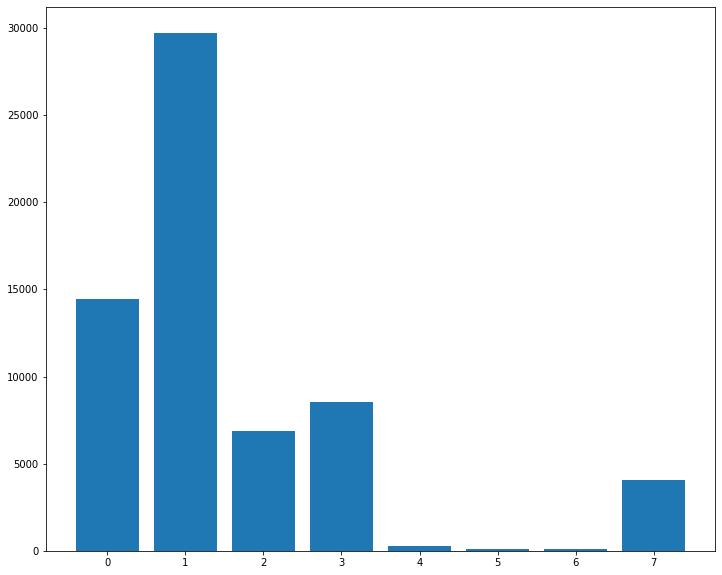

In [49]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(cleaned_df, test_size=0.2)

from collections import Counter

counter = Counter(train_df['label'])
plt.bar(counter.keys(), counter.values())
plt.show()



In [50]:
# Form np arrays of labels and features.
from keras.utils import np_utils
train_labels = np_utils.to_categorical(train_df.pop('label'))
val_labels = np_utils.to_categorical(val_df.pop('label'))
test_labels = np_utils.to_categorical(test_df.pop('label'))
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

train_features[0]

array([248, 504, 556, 0, 0, 4, 0, 0, 107.0, 2.3026850879943788,
       3.7376934275237357, 10.18572989394209, True, False, False, 1, 2],
      dtype=object)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [51]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (64128, 8)
Validation labels shape: (16032, 8)
Test labels shape: (16032, 8)
Training features shape: (64128, 17)
Validation features shape: (16032, 17)
Test features shape: (16032, 17)


In [64]:
final_train_df = cleaned_df.copy()
test_final_df = final_test_df.copy()

final_train_labels = np_utils.to_categorical(final_train_df.pop('label'))
final_train_features = np.array(final_train_df)
final_test_features = np.array(test_final_df)


In [65]:
scaler = StandardScaler()
final_train_features = scaler.fit_transform(final_train_features)
final_test_features = scaler.transform(final_test_features)

final_train_features = np.clip(final_train_features, -5, 5)
final_test_features = np.clip(final_test_features, -5, 5)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [52]:


def make_model():
  input =  tf.keras.Input(shape=train_df.shape[1:])
  x = tf.keras.layers.Flatten()(input)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dense(32, activation='relu')(x)
  output = tf.keras.layers.Dense(8, activation='softmax')(x)
  model = tf.keras.models.Model(input,output)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss= tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.FalseNegatives(),
                        tf.keras.metrics.AUC(name='prc', curve='PR')])

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [58]:
model = make_model()
model.summary()
print(f'Train Features Shape: {train_features.shape} \nTrain Labels Shape: {train_labels.shape}')


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 17)]              0         
                                                                 
 flatten_11 (Flatten)        (None, 17)                0         
                                                                 
 dense_44 (Dense)            (None, 128)               2304      
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12,904
Trainable params: 12,904
Non-trainabl

In [59]:
model.fit(x=train_features, y=train_labels, epochs=20, validation_data=(val_features, val_labels))

Epoch 1/20
2004/2004 [==============================] - 6s 3ms/step - loss: 0.9930 - categorical_accuracy: 0.5173 - false_negatives_11: 42457.0000 - prc: 0.5697 - val_loss: 0.9133 - val_categorical_accuracy: 0.5377 - val_false_negatives_11: 9806.0000 - val_prc: 0.5980
Epoch 2/20
2004/2004 [==============================] - 5s 3ms/step - loss: 0.9016 - categorical_accuracy: 0.5435 - false_negatives_11: 38356.0000 - prc: 0.6063 - val_loss: 0.8831 - val_categorical_accuracy: 0.5451 - val_false_negatives_11: 9573.0000 - val_prc: 0.6125
Epoch 3/20
2004/2004 [==============================] - 5s 3ms/step - loss: 0.8769 - categorical_accuracy: 0.5533 - false_negatives_11: 36993.0000 - prc: 0.6172 - val_loss: 0.8736 - val_categorical_accuracy: 0.5536 - val_false_negatives_11: 8956.0000 - val_prc: 0.6166
Epoch 4/20
2004/2004 [==============================] - 5s 2ms/step - loss: 0.8601 - categorical_accuracy: 0.5589 - false_negatives_11: 36286.0000 - prc: 0.6254 - val_loss: 0.8574 - val_categor

In [60]:
model.evaluate(test_features, test_labels)

501/501 [==============================] - 1s 2ms/step - loss: 0.7700 - categorical_accuracy: 0.5883 - false_negatives_11: 7940.0000 - prc: 0.6623


[0.770035982131958, 0.5882609486579895, 7940.0, 0.6622918844223022]

Test run the model:

In [ ]:
model.predict(train_features[:10])

array([[0.11142252, 0.09038334, 0.144186  , 0.11137723, 0.13216093,
        0.04528884, 0.19939128, 0.0359086 , 0.07870894, 0.05117223],
       [0.17225793, 0.1569241 , 0.17104441, 0.1319198 , 0.03390858,
        0.02385597, 0.13659541, 0.06252219, 0.08994907, 0.0210226 ],
       [0.0616394 , 0.0030935 , 0.43976957, 0.2348534 , 0.14348063,
        0.01287365, 0.06028781, 0.02321327, 0.00905443, 0.01173433],
       [0.15454103, 0.04124064, 0.19037873, 0.15015115, 0.08832957,
        0.05889321, 0.15037756, 0.08902869, 0.04942388, 0.02763564],
       [0.2156234 , 0.05252496, 0.18978442, 0.03456469, 0.02569761,
        0.04801705, 0.18725494, 0.05280324, 0.10957126, 0.08415842],
       [0.07269286, 0.04301731, 0.19513455, 0.13259558, 0.16958396,
        0.07952046, 0.17019378, 0.04579668, 0.04517747, 0.04628743],
       [0.07903624, 0.04215971, 0.1663548 , 0.13221204, 0.21732591,
        0.07378722, 0.17485821, 0.0394065 , 0.03792994, 0.03692946],
       [0.16150431, 0.14974163, 0.1836476

In [61]:
model = make_model()
model.summary()
print(f'Train Features Shape: {train_features.shape} \nTrain Labels Shape: {train_labels.shape}')

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 17)]              0         
                                                                 
 flatten_12 (Flatten)        (None, 17)                0         
                                                                 
 dense_48 (Dense)            (None, 128)               2304      
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 dense_50 (Dense)            (None, 32)                2080      
                                                                 
 dense_51 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12,904
Trainable params: 12,904
Non-trainabl

In [66]:
model.fit(x=final_train_features, y=final_train_labels, epochs=20)

Epoch 1/20
2505/2505 [==============================] - 6s 2ms/step - loss: 0.9792 - categorical_accuracy: 0.5212 - false_negatives_12: 52242.0000 - prc: 0.5758
Epoch 2/20
2505/2505 [==============================] - 5s 2ms/step - loss: 0.8927 - categorical_accuracy: 0.5456 - false_negatives_12: 47761.0000 - prc: 0.6104
Epoch 3/20
2505/2505 [==============================] - 5s 2ms/step - loss: 0.8679 - categorical_accuracy: 0.5535 - false_negatives_12: 46294.0000 - prc: 0.6212
Epoch 4/20
2505/2505 [==============================] - 5s 2ms/step - loss: 0.8498 - categorical_accuracy: 0.5596 - false_negatives_12: 45461.0000 - prc: 0.6290
Epoch 5/20
2505/2505 [==============================] - 5s 2ms/step - loss: 0.8352 - categorical_accuracy: 0.5640 - false_negatives_12: 44705.0000 - prc: 0.6353
Epoch 6/20
2505/2505 [==============================] - 5s 2ms/step - loss: 0.8230 - categorical_accuracy: 0.5700 - false_negatives_12: 43548.0000 - prc: 0.6408
Epoch 7/20
2505/2505 [============

In [67]:
predictions = model.predict(final_test_features)

1074/1074 [==============================] - 1s 1ms/step


In [69]:
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 1, 1, ..., 1, 7, 1], dtype=int64)

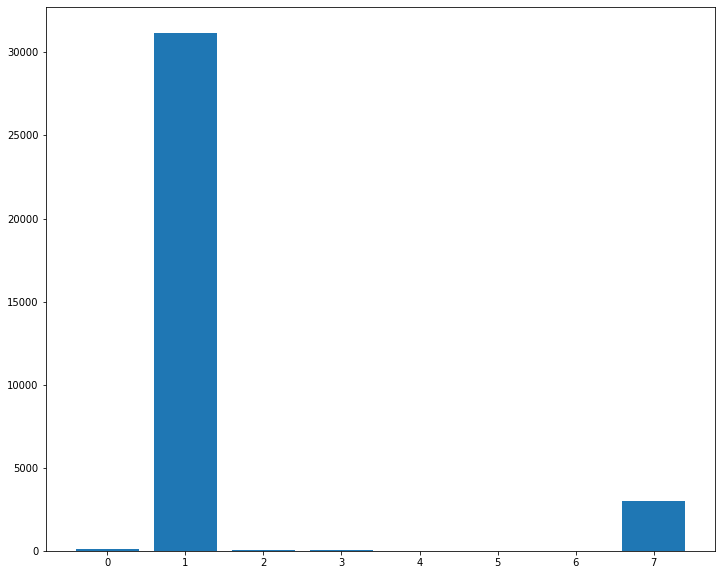

In [70]:
counter = Counter(predictions)
plt.bar(counter.keys(), counter.values())
plt.show()

In [71]:
pd.DataFrame(predictions, columns=['label']).to_csv('keras.csv')

In [72]:
final_train_df = cleaned_df.copy()
test_final_df = final_test_df.copy()

final_train_labels = np_utils.to_categorical(final_train_df.pop('label'))
final_train_features = np.array(final_train_df)
final_test_features = np.array(test_final_df)

scaler = StandardScaler()
final_train_features = scaler.fit_transform(final_train_features)
final_test_features = scaler.transform(final_test_features)

final_train_features = np.clip(final_train_features, -5, 5)
final_test_features = np.clip(final_test_features, -5, 5)


In [73]:
from imblearn.combine import SMOTETomek

oversample = SMOTETomek()
final_train_features, final_train_labels = oversample.fit_resample(final_train_features, final_train_labels)

TypeError: unhashable type: 'numpy.ndarray'

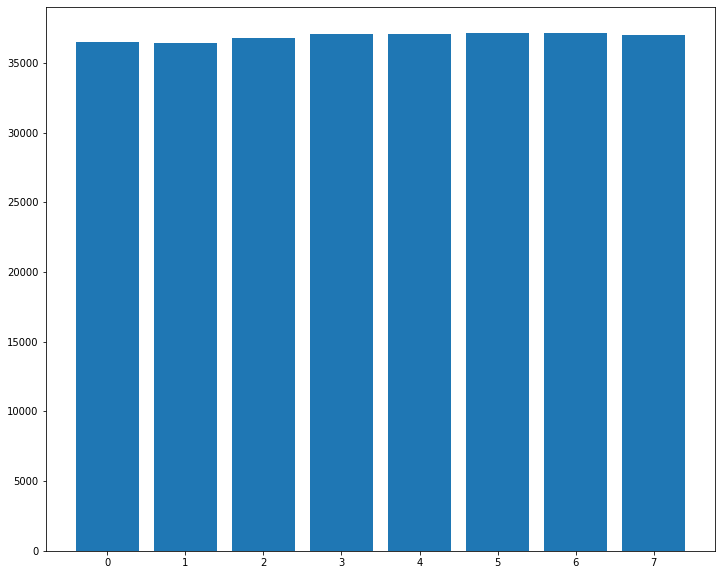

In [76]:
counter = Counter(np.argmax(final_train_labels, axis=1))
plt.bar(counter.keys(), counter.values())
plt.show()

In [77]:
model = make_model()
model.summary()
print(f'Train Features Shape: {train_features.shape} \nTrain Labels Shape: {train_labels.shape}')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 17)]              0         
                                                                 
 flatten_13 (Flatten)        (None, 17)                0         
                                                                 
 dense_52 (Dense)            (None, 128)               2304      
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dense_55 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12,904
Trainable params: 12,904
Non-trainabl

In [78]:
model.fit(x=final_train_features, y=final_train_labels, epochs=50)

Epoch 1/50
9227/9227 [==============================] - 20s 2ms/step - loss: 0.6195 - categorical_accuracy: 0.7755 - false_negatives_13: 85701.0000 - prc: 0.8579
Epoch 2/50
9227/9227 [==============================] - 19s 2ms/step - loss: 0.4896 - categorical_accuracy: 0.8204 - false_negatives_13: 64282.0000 - prc: 0.8984
Epoch 3/50
9227/9227 [==============================] - 19s 2ms/step - loss: 0.4616 - categorical_accuracy: 0.8312 - false_negatives_13: 58986.0000 - prc: 0.9067
Epoch 4/50
9227/9227 [==============================] - 20s 2ms/step - loss: 0.4454 - categorical_accuracy: 0.8368 - false_negatives_13: 56323.0000 - prc: 0.9112
Epoch 5/50
9227/9227 [==============================] - 19s 2ms/step - loss: 0.4330 - categorical_accuracy: 0.8412 - false_negatives_13: 54272.0000 - prc: 0.9147
Epoch 6/50
9227/9227 [==============================] - 19s 2ms/step - loss: 0.4248 - categorical_accuracy: 0.8433 - false_negatives_13: 53235.0000 - prc: 0.9169
Epoch 7/50
9227/9227 [======

In [79]:
predictions = model.predict(final_test_features)
predictions = np.argmax(predictions, axis=1)
predictions

1074/1074 [==============================] - 2s 2ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

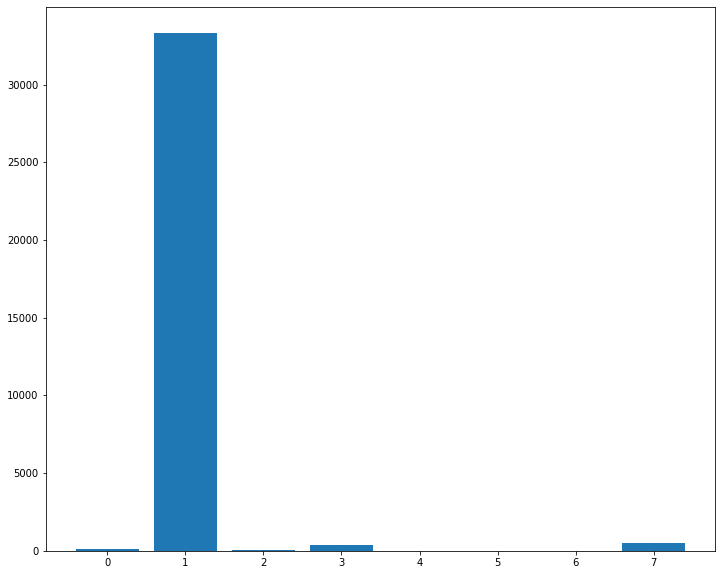

In [80]:
counter = Counter(predictions)
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
pd.DataFrame(predictions, columns=['label']).to_csv('keras_oversampling.csv')